# Pre-trained ViT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.8/731.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

In [ ]:
MLFLOW_TRACKING_URI = "file:///content/drive/MyDrive/my_model/mlruns/"
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI])

<Popen: returncode: None args: ['mlflow', 'ui', '--backend-store-uri', 'file...>

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("pretrained-vit-model")

<Experiment: artifact_location='file:///content/drive/MyDrive/my_model/mlruns/425829015634956416', creation_time=1700962647734, experiment_id='425829015634956416', last_update_time=1700962647734, lifecycle_stage='active', name='pretrained-vit-model', tags={}>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


 * ngrok tunnel "https://6a19-34-16-130-35.ngrok-free.app" -> "http://127.0.0.1:5000"


In [ ]:
! cp drive/MyDrive/helper_functions.py .

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

## Pre-trained Vit Modeling

In [ ]:
!unzip drive/MyDrive/DATASET.zip
!unzip drive/MyDrive/going_modular.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_7746.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_8475.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_8475.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_1323.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_1323.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_7752.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_7752.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_8461.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_8461.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_3534.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_3534.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_5145.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_5145.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_5623.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclable/._R_5623.jpg  
  inflating: DATASET/TRAIN/Recyclable/R_3252.jpg  
  inflating: __MACOSX/DATASET/TRAIN/Recyclabl

In [ ]:
!pip install torchinfo --quiet

## Helper functions

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Change the classifier head
class_names = ['Organic', 'Recyclable']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 55.0MB/s]


In [ ]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
train_dir = '/content/DATASET/TRAIN'
test_dir = '/content/DATASET/TEST'

In [ ]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

import mlflow
import mlflow.pytorch


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    model.to(device)

    checkpoint_path = '/content/drive/My Drive/my_model/vit_model_pre/model_checkpoint.pth'

    try:
      if torch.cuda.is_available():
          device = torch.device("cuda")
      else:
          device = torch.device("cpu")

      if torch.cuda.is_available():
          map_location = lambda storage, loc: storage.cuda()
      else:
          map_location = 'cpu'

      if torch.cuda.is_available():
          checkpoint = torch.load(checkpoint_path, map_location=map_location)
      else:
          checkpoint = torch.load(checkpoint_path, map_location=map_location)

      if 'epoch' in checkpoint:
          start_epoch = checkpoint['epoch'] + 1
          model.load_state_dict(checkpoint['model_state_dict'])
          optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
      else:
          start_epoch = 0
    except FileNotFoundError:
      start_epoch = 0

    mlflow.end_run()

    with mlflow.start_run() as run:
      for epoch in tqdm(range(start_epoch, epochs)):
          train_loss, train_acc = train_step(model=model,
                                            dataloader=train_dataloader,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
          test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

          print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
          )

          # Update results dictionary
          results["train_loss"].append(train_loss)
          results["train_acc"].append(train_acc)
          results["test_loss"].append(test_loss)
          results["test_acc"].append(test_acc)
          torch.save({
              'epoch': epoch,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()}, checkpoint_path)

          log_epoch = epoch+1
          mlflow.log_metric("Epoch", log_epoch, step=log_epoch)
          mlflow.log_metric("train_loss", round(train_loss, 4), step=log_epoch)
          mlflow.log_metric("train_acc", round(train_acc, 4), step=log_epoch)
          mlflow.log_metric("test_loss", round(test_loss, 4), step=log_epoch)
          mlflow.log_metric("test_acc", round(test_acc, 4), step=log_epoch)

    return results


In [ ]:
# Optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=0.0001) # 1e-3
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1266 | train_acc: 0.9560 | test_loss: 0.2065 | test_acc: 0.9069
Epoch: 2 | train_loss: 0.1236 | train_acc: 0.9565 | test_loss: 0.2031 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.1218 | train_acc: 0.9570 | test_loss: 0.2062 | test_acc: 0.9053
Epoch: 4 | train_loss: 0.1194 | train_acc: 0.9576 | test_loss: 0.2037 | test_acc: 0.9057
Epoch: 5 | train_loss: 0.1180 | train_acc: 0.9581 | test_loss: 0.2051 | test_acc: 0.9042
Epoch: 6 | train_loss: 0.1167 | train_acc: 0.9587 | test_loss: 0.2034 | test_acc: 0.9062
Epoch: 7 | train_loss: 0.1154 | train_acc: 0.9587 | test_loss: 0.2045 | test_acc: 0.9057
Epoch: 8 | train_loss: 0.1148 | train_acc: 0.9586 | test_loss: 0.1995 | test_acc: 0.9077
Epoch: 9 | train_loss: 0.1142 | train_acc: 0.9590 | test_loss: 0.2012 | test_acc: 0.9077
Epoch: 10 | train_loss: 0.1130 | train_acc: 0.9598 | test_loss: 0.2034 | test_acc: 0.9069


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


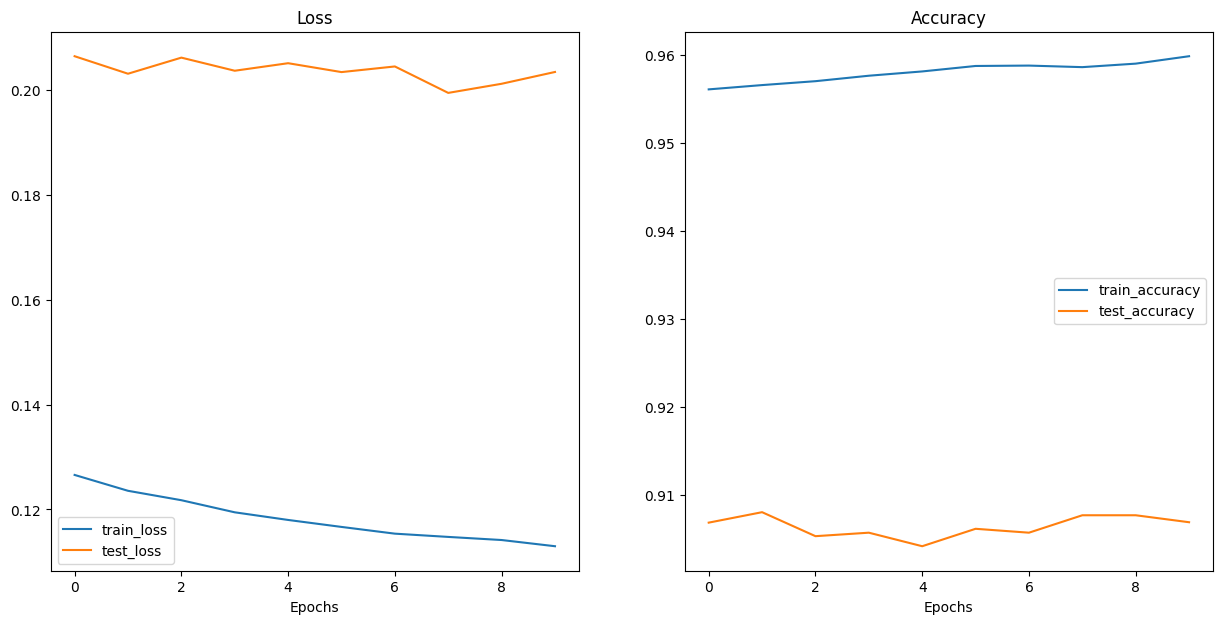

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

# Inference:

In [ ]:
# Inference
import torch

checkpoint_path = '/content/drive/My Drive/my_model/vit_model_pre/model_checkpoint.pth'

if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()
else:
    map_location = 'cpu'

if torch.cuda.is_available():
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
else:
    checkpoint = torch.load(checkpoint_path, map_location=map_location)

pretrained_vit.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

In [ ]:
# Confusion Matrix

y_pred = []
y_true = []

pretrained_vit.to(device)

pretrained_vit.eval()

test_loss, test_acc = 0, 0

with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dataloader_pretrained):
        X, y = X.to(device), y.to(device)

        test_pred_logits = pretrained_vit(X)

        test_pred_labels = test_pred_logits.argmax(dim=1)
        y_pred.extend(test_pred_labels)
        y_true.extend(y)

classes = ('Organic', 'Recyclable')

In [ ]:
cpu_pred = [t.cpu() for t in y_pred]
cpu_true = [t.cpu() for t in y_true]


numpy_array_pred = [t.numpy() for t in cpu_pred]
numpy_array_true = [t.numpy() for t in cpu_true]

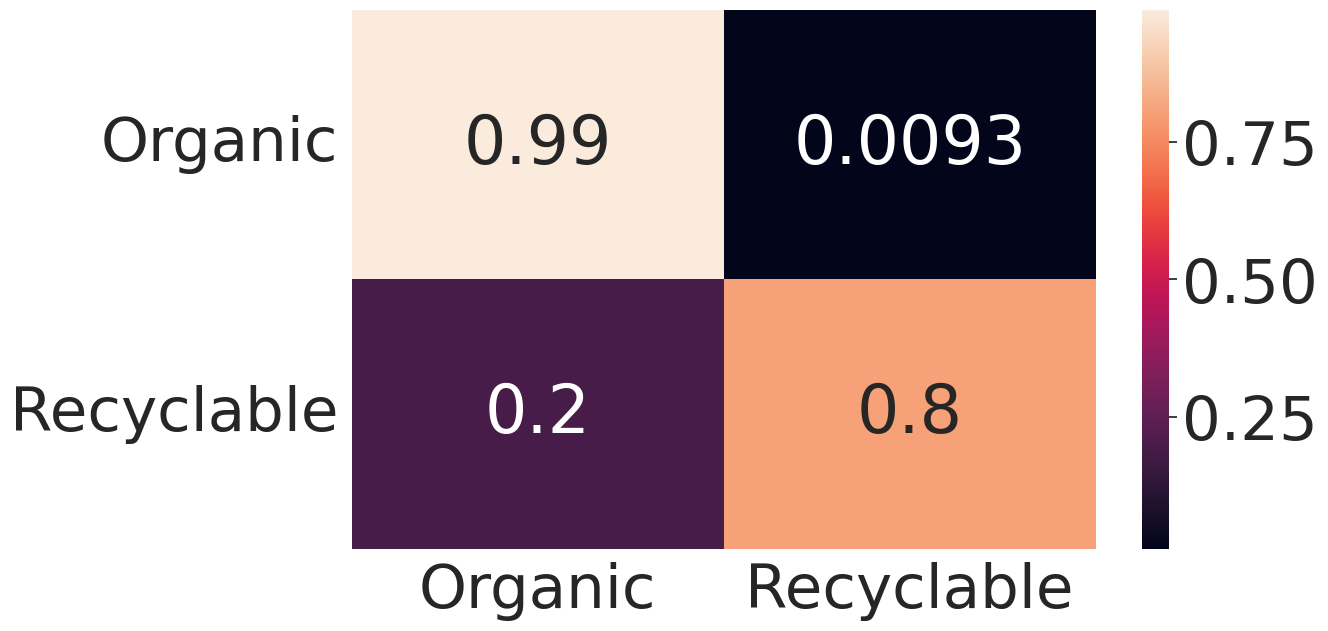

In [ ]:
# Build confusion matrix
cf_matrix = confusion_matrix(numpy_array_true, numpy_array_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.set(font_scale=4.0)
sn.heatmap(df_cm, annot=True)
plt.savefig('cm_pre_trained.png')

In [ ]:
# Calculate the precision
precision = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[0, 1])

# Calculate the recall
recall = cf_matrix[0, 0] / (cf_matrix[0, 0] + cf_matrix[1, 0])

# Calculate the F1 score
f1_score = 2 * precision * recall / (precision + recall)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Precision: 0.9907209136331192
Recall: 0.864797507788162
F1 score: 0.9234863606121091


       Models  Precision  Recall  F1-Score  Accuracy
0  Custom-ViT         99      86        92        86
1  Fine-tuned         99      86        92        90


<Axes: title={'center': 'Evaluation Metrics'}, xlabel='Models'>

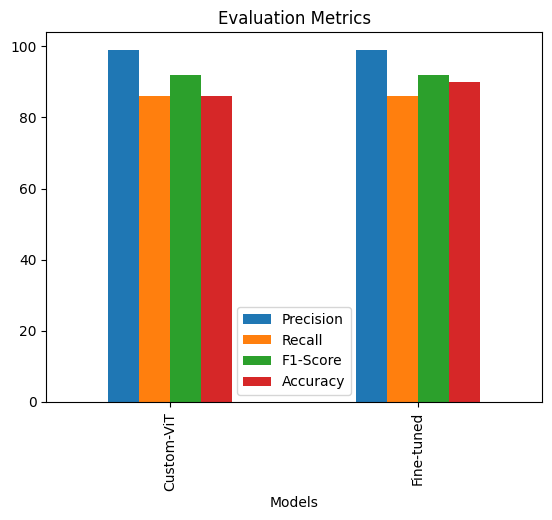

In [ ]:
# importing package
import matplotlib.pyplot as plt
import pandas as pd

# create data
df = pd.DataFrame([['Custom-ViT', 99, 86, 92, 86], ['Fine-tuned', 99, 86, 92, 90]],
                  columns=['Models', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])
# view data
print(df)

# plot grouped bar chart
df.plot(x='Models',
        kind='bar',
        stacked=False,
        title='Evaluation Metrics')